# Model: naive_baseline_1

**Based on naive_baseline_0, and also take the user's previous assessment result into consideration.**

### Results

- Validation qwk_score: 0.49
- Test qwk_score (public): 0.422 
- Test qwk_score (private): 0.442 

In [1]:
import os
from sys import getsizeof
import time
import re
from importlib import reload
import joblib 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import make_scorer 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

import xgboost
from xgboost import plot_importance
from xgboost.sklearn import XGBRegressor 

from data_util import *
from model_util import *

# for auto reload a module after editing.
%load_ext autoreload
%autoreload 2

/Users/zhao/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [71]:
# Input data path
DATA_DIR  = os.path.join('.', 'input')
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'test.csv')
TRAIN_LABEL_PATH = os.path.join(DATA_DIR, 'train_labels.csv')

# Read input data
print("\n/########## Load Data ##########/\n")
t0 = time.time()
train_df = pd.read_csv(TRAIN_PATH)
t1 = time.time()
test_df  = pd.read_csv(TEST_PATH)
t2 = time.time()
# train_label_df = pd.read_csv(TRAIN_LABEL_PATH)
print('train_df shape:', train_df.shape, ', load time: {0:.1f} seconds.'.format((t1 - t0)))
print('test_df shape:', test_df.shape, ', load time: {0:.1f} seconds.'.format((t2 - t1)))


/########## Load Data ##########/

train_df shape: (11341042, 11) , load time: 82.0 seconds.
test_df shape: (1156414, 11) , load time: 7.7 seconds.


# Process Data

- **train_df, test_df**: raw data
- **train_label_df, test_label_df**: dataframes recording each assessment result.
- **train_proc_df, test_proc_df**: dataframes recording features extracted from each session.

In [72]:
# Setup directory
PROC_DIR = os.path.join('.', 'processed')
if not os.path.exists(PROC_DIR):
    os.makedirs(PROC_DIR)
    
TRAIN_LABEL_PATH_ = os.path.join(PROC_DIR, 'train_labels_sortByTime.csv')
TEST_LABEL_PATH_  = os.path.join(PROC_DIR, 'test_labels_sortByTime.csv')
TRAIN_PROC_PATH = os.path.join(PROC_DIR, 'train_proc.csv')
TEST_PROC_PATH  = os.path.join(PROC_DIR, 'test_proc.csv')

# Get label_df
print("\n/########## Extract label_df ##########/\n")
get_label_csv(train_df, TRAIN_LABEL_PATH_, is_test=False)
get_label_csv(test_df, TEST_LABEL_PATH_, is_test=True)
train_label_df = pd.read_csv(TRAIN_LABEL_PATH_)
test_label_df  = pd.read_csv(TEST_LABEL_PATH_)

TRAIN_USERS = train_df['installation_id'].unique()
TRAIN_USERS_wLabel = train_label_df['installation_id'].unique()
TEST_USERS  = test_df['installation_id'].unique()
TEST_USERS_wMultiAssess = test_label_df.dropna()['installation_id'].unique()    # can be used as part of train.
print('TRAIN_USERS num: ', len(TRAIN_USERS))
print('TRAIN_USERS_wLabel num: ', len(TRAIN_USERS_wLabel))
print('TEST_USERS num: ', len(TEST_USERS))
print('TEST_USERS_wMultiAssess num: ', len(TEST_USERS_wMultiAssess))


/########## Extract label_df ##########/

Finished extracting labels. Time: 64.2 seconds.
Finished extracting labels. Time: 6.0 seconds.
TRAIN_USERS num:  17000
TRAIN_USERS_wLabel num:  3614
TEST_USERS num:  1000
TEST_USERS_wMultiAssess num:  557


# Validation

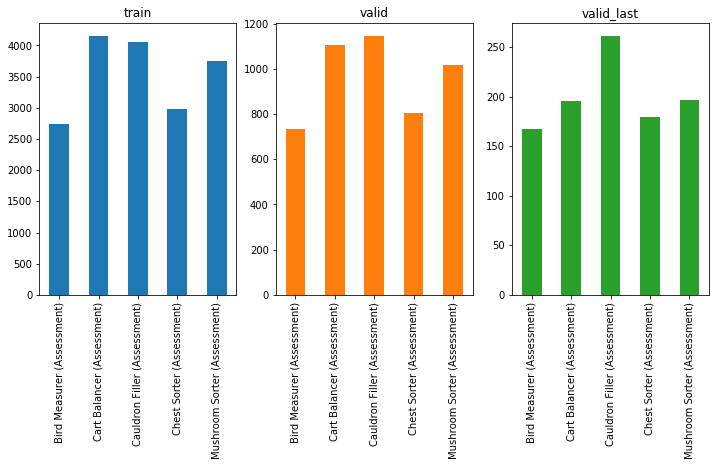

In [303]:
# Sampling 1000 samples as validation set 
valid_num = 1000
valid_users = np.random.choice(TRAIN_USERS_wLabel, valid_num, replace=False)
valid_label_df = train_label_df[train_label_df['installation_id'].isin(valid_users)]
valid_label_df_last = valid_label_df.groupby('installation_id').tail(1)
valid_label_df_not_last = valid_label_df.loc[[index for index in valid_label_df.index if index not in valid_label_df_last.index]]
valid_label_df_not_last['percentile'] = np.nan

# Plot the histogram of assessment types.
df_assessment_counts = pd.DataFrame(columns=['train', 'valid', 'valid_last'])
df_assessment_counts['train'] = pd.Series(train_label_df['title'].values).value_counts().sort_index()
df_assessment_counts['valid'] = pd.Series(valid_label_df['title'].values).value_counts().sort_index()
df_assessment_counts['valid_last'] = pd.Series(valid_label_df_last['title'].values).value_counts().sort_index()
_ = df_assessment_counts.plot(kind='bar', figsize=(12, 5), subplots=True, layout=(1,3), legend=False)

In [304]:
assessments = ['Bird Measurer (Assessment)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 
               'Chest Sorter (Assessment)', 'Mushroom Sorter (Assessment)']

# Get the percentile of users' performance in each assessment.
for assessment in assessments:
    train_label_df_assess = train_label_df[train_label_df['title'] == assessment].sort_values(by=['accuracy']) 
    train_acc_list_assess = train_label_df_assess['accuracy'].values
    valid_label_df_assess = valid_label_df_not_last[valid_label_df_not_last['title'] == assessment]
    valid_acc_list_assess = valid_label_df_assess['accuracy'].values
    valid_label_df_assess.loc[:, 'percentile'] = (0.5 * np.searchsorted(train_acc_list_assess, valid_acc_list_assess, side='right') 
                                                  + 0.5 *  np.searchsorted(train_acc_list_assess, valid_acc_list_assess, side='left')) / len(train_acc_list_assess)
    valid_label_df_not_last.loc[valid_label_df_assess.index, 'percentile'] = valid_label_df_assess['percentile']
valid_user_percentile = valid_label_df_not_last.groupby('installation_id').agg({'percentile': 'mean'})
valid_user_percentile

/Users/zhao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,percentile
installation_id,
003372b0,0.599042
00fa8681,0.490689
01825124,0.679443
01bdd720,0.630927
0293ae74,0.489132
...,...
fe488283,0.485069
fe4d880a,0.383285
ff9305d7,0.308374


In [305]:
# Prediction

# Step 1: same as 'naive_baseline_0'
assessment_dict = {
    'Bird Measurer (Assessment)' : 0,
    'Cart Balancer (Assessment)' : 3,
    'Cauldron Filler (Assessment)' : 3,
    'Chest Sorter (Assessment)': 0,
    'Mushroom Sorter (Assessment)': 3
}

y_valid_truth = valid_label_df_last['accuracy_group'].values
y_valid_pred  = [assessment_dict[assessment] for assessment in valid_label_df_last['title']]
res_df = pd.DataFrame()
res_df['installation_id'] = valid_label_df_last['installation_id']
res_df['title'] = valid_label_df_last['title']
res_df['accuracy_group_truth'] = y_valid_truth
res_df['accuracy_group_pred'] = y_valid_pred
res_df.set_index('installation_id', inplace=True)

# Step 2: if the user has already taken assessments, use that result to do prediction
assessment_to_group_list = {}
for assessment in assessments:
    group_list = train_label_df[train_label_df['title'] == assessment].sort_values(by=['accuracy_group'])['accuracy_group'].values
    assessment_to_group_list[assessment] = group_list

for uid in res_df.index:
    if uid not in valid_user_percentile.index:
        continue
    percentile = valid_user_percentile.loc[uid, 'percentile']
    assessment = res_df.loc[uid, 'title']
    group_list = assessment_to_group_list[assessment]
    res_df.loc[uid, 'accuracy_group_pred'] = group_list[int(len(group_list) * percentile) - 1]
    
y_valid_pred = res_df['accuracy_group_pred'].values

Assessment = Bird Measurer (Assessment): qwk_score = 0.27
Assessment = Cart Balancer (Assessment): qwk_score = 0.19
Assessment = Cauldron Filler (Assessment): qwk_score = 0.25
Assessment = Chest Sorter (Assessment): qwk_score = 0.23
Assessment = Mushroom Sorter (Assessment): qwk_score = 0.15
Overall: r2_score = 0.01
Overall: qwk_score = 0.49


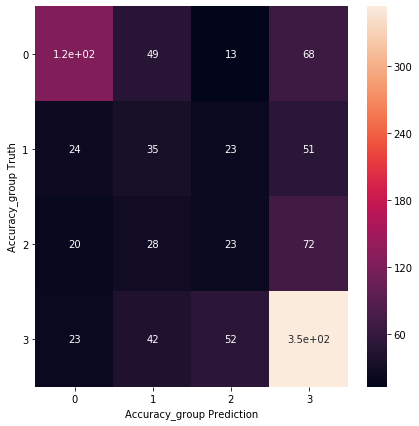

In [306]:
for assessment in assessments:
    assessment_truth = res_df[res_df['title'] == assessment]['accuracy_group_truth'].values
    assessment_pred  = res_df[res_df['title'] == assessment]['accuracy_group_pred'].values
    assessment_qwk = cohen_kappa_score(assessment_truth, assessment_pred, weights='quadratic')
    print('Assessment = {}: qwk_score = {:.2f}'.format(assessment, assessment_qwk))

r2 = r2_score(y_valid_truth, y_valid_pred) 
print('Overall: r2_score = {:.2f}'.format(r2))
qwk_score = cohen_kappa_score(y_valid_truth, y_valid_pred, weights='quadratic')
print('Overall: qwk_score = {:.2f}'.format(qwk_score))
plot_acc_group_cm(y_valid_truth, y_valid_pred)

# Test

In [346]:
test_label_df_last = test_label_df.groupby('installation_id').tail(1)
test_label_df_not_last = test_label_df.loc[[index for index in test_label_df.index if index not in test_label_df_last.index]]
test_label_df_not_last['percentile'] = np.nan

assessments = ['Bird Measurer (Assessment)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 
               'Chest Sorter (Assessment)', 'Mushroom Sorter (Assessment)']

# Get the percentile of users' performance in each assessment.
for assessment in assessments:
    train_label_df_assess = train_label_df[train_label_df['title'] == assessment].sort_values(by=['accuracy']) 
    train_acc_list_assess = train_label_df_assess['accuracy'].values
    test_label_df_assess = test_label_df_not_last[test_label_df_not_last['title'] == assessment]
    test_acc_list_assess = test_label_df_assess['accuracy'].values
    fac = 0.5
    test_label_df_assess.loc[:, 'percentile'] = (fac * np.searchsorted(train_acc_list_assess, test_acc_list_assess, side='right') 
                                                  + (1 - fac) *  np.searchsorted(train_acc_list_assess, test_acc_list_assess, side='left')) \
                                                    / len(train_acc_list_assess)
    test_label_df_not_last.loc[test_label_df_assess.index, 'percentile'] = test_label_df_assess['percentile']
test_user_percentile = test_label_df_not_last.groupby('installation_id').agg({'percentile': 'mean'})


# Prediction

# Step 1: same as 'naive_baseline_0'
assessment_dict = {
    'Bird Measurer (Assessment)' : 0,
    'Cart Balancer (Assessment)' : 3,
    'Cauldron Filler (Assessment)' : 3,
    'Chest Sorter (Assessment)': 0,
    'Mushroom Sorter (Assessment)': 3
}

submission_df = pd.DataFrame()
submission_df['installation_id'] = test_label_df_last['installation_id'].values
submission_df['title'] = test_label_df_last['title'].values
submission_df['accuracy_group']  = [assessment_dict[assessment] for assessment in test_label_df_last['title']]
submission_df.set_index('installation_id', inplace=True)

# Step 2: if the user has already taken assessments, use that result to do prediction
assessment_to_group_list = {}
for assessment in assessments:
    group_list = train_label_df[train_label_df['title'] == assessment].sort_values(by=['accuracy_group'])['accuracy_group'].values
    assessment_to_group_list[assessment] = group_list

for uid in submission_df.index:
    if uid not in test_user_percentile.index:
        continue
    percentile = test_user_percentile.loc[uid, 'percentile']
    assessment = submission_df.loc[uid, 'title']
    group_list = assessment_to_group_list[assessment]
    submission_df.loc[uid, 'accuracy_group'] = group_list[int(len(group_list) * percentile) - 1]


In [355]:
OUTPUT_DIR  = os.path.join('.', 'output')
submission_df.reset_index()[['installation_id', 'accuracy_group']].to_csv('submission.csv', index=False)